<a href="https://colab.research.google.com/github/Redwoods/Py/blob/master/pdm2020/my-note/py-tensorflow/tf2_7_fmnist_CNN_best.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CNN model of fmnist dataset**
- Conv2D + FCN
    * Conv2D : 2차원 합성곱 필터링 + 풀링(Pooling)
    * FCN : 1차원 완전연결신경망

***
- ## Traget: Find the best model
***

![mnist_NN_2_layers](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdJp5Z6%2FbtqAPebnF3x%2FQCe5vVcskhmxe964bGz4iK%2Fimg.png)

(source: https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdJp5Z6%2FbtqAPebnF3x%2FQCe5vVcskhmxe964bGz4iK%2Fimg.png)

## dataset: fashion_mnist
- (60000, 28, 28), train
- (10000, 28, 28), test
- grayscale images of items of 10 types of clothings, such as shoes, t-shirts, dresses, and more.
- class names
> class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

- DL of fmnist
> https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-fashion-mnist-clothing-classification/


## Search the best model of C2F2
- callback
    - Early stopping
    - model checkpoint

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

tf.random.set_seed(0)

print(tf.__version__)

2.3.0


In [2]:
# import TF2 submodules
from tensorflow.keras import layers, models, callbacks

## **데이터 로딩, 정규화**

In [3]:
from keras.datasets import fashion_mnist

(X_train0, y_train0), (X_test0, y_test0) = fashion_mnist.load_data()

# Reshape
X_train = X_train0.reshape(60000,28,28,1)
X_test = X_test0.reshape(10000,28,28,1)

# Normalization
X_train, X_test = X_train/255.0, X_test/255.0 # 정규화

print("X_train={0}".format(X_train.shape))
print("y_train={0}".format(y_train0.shape)) 
print("X_test={0}".format(X_test.shape))
print("y_test={0}".format(y_test0.shape))

4423680/4422102 [==============================] - 0s 0us/step
X_train=(60000, 28, 28, 1)
y_train=(60000,)
X_test=(10000, 28, 28, 1)
y_test=(10000,)


In [4]:
# One-Hot-Encoding
# Use function to_categorical() to do One-Hot-Encoding
# tf.keras.utils.to_categorical
from keras.utils import to_categorical

y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)
y_train.shape,y_test.shape

((60000, 10), (10000, 10))

In [5]:
# y_train0.shape vs. y_train.shape
y_train0.shape, y_train.shape

((60000,), (60000, 10))

### Display fashions
- one random fashion
- 10 representative fashions

42709


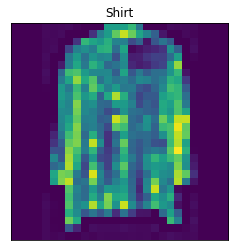

In [6]:
# Code here!
# display one random image from the training set:
class_names =  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

idx = np.random.randint(0, X_train0.shape[0])
print(idx)
image = X_train0[idx]
plt.imshow(image) #, cmap=plt.get_cmap('gray'))
plt.title(class_names[y_train0[idx]])
plt.xticks([])
plt.yticks([])
plt.show()

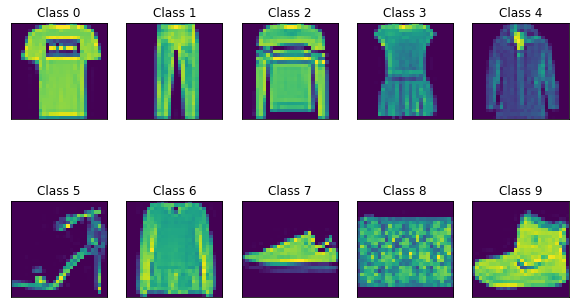

In [7]:
fig = plt.figure(figsize=(10,6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    num0_9 = X_train0[y_train0 == i]
    # print(num0_9.shape)
    plt.imshow(num0_9[0]) #, cmap='gray') #, interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])

# Design CNN

### import models, layers, callbacks
- models: Sequential
- layers: Conv2D, MaxPool2D, Flatten
- callbacks: ModelCheckpoint, EarlyStopping

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping

## **CNN2 + FCN2**

In [9]:
c2f2 = keras.models.Sequential([ 
    Conv2D(input_shape=(28,28,1),kernel_size=(3,3),strides=(1,1),filters= 32,padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)), 
    Conv2D(kernel_size=(3,3),strides=(1,1),filters= 64,padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Flatten(), 
    keras.layers.Dense(128, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(10, activation='softmax')
])

c2f2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

In [10]:
c2f2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               401536    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [11]:
cp_callback = callbacks.ModelCheckpoint(filepath="./fmnist_c2f2_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=50)    # patience=20, 50

In [12]:
hist = c2f2.fit(X_train, y_train, epochs = 500 , batch_size =32, 
         callbacks=[cp_callback, es_callback], 
         validation_data=(X_test,y_test))

Epoch 1/500
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4336 - accuracy: 0.8439 - val_loss: 0.3217 - val_accuracy: 0.8855
Epoch 2/500
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2854 - accuracy: 0.8963 - val_loss: 0.2660 - val_accuracy: 0.9022
Epoch 3/500
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2398 - accuracy: 0.9118 - val_loss: 0.2512 - val_accuracy: 0.9071
Epoch 4/500
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2074 - accuracy: 0.9225 - val_loss: 0.2416 - val_accuracy: 0.9113
Epoch 5/500
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1873 - accuracy: 0.9302 - val_loss: 0.2580 - val_accuracy: 0.9119
Epoch 6/500
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1658 - accuracy: 0.9387 - val_loss: 0.2296 - val_accuracy: 0.9209
Epoch 7/500
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1484 - accuracy: 0.9433 - val_loss: 0.2355 - val_ac

In [13]:
c2f2.evaluate(X_test, y_test, batch_size =32)

313/313 [==============================] - 1s 2ms/step - loss: 0.6810 - accuracy: 0.9141


[0.6810128688812256, 0.9140999913215637]

## **CNN2 + FCN3**

In [14]:
c2f3 = keras.models.Sequential([ 
    Conv2D(input_shape=(28,28,1),kernel_size=(3,3),strides=(1,1),filters= 32,padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)), 
    Conv2D(kernel_size=(3,3),strides=(1,1),filters= 64,padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Flatten(), 
    keras.layers.Dense(128, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(64, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(10, activation='softmax')
])

c2f3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']) 

In [15]:
c2f3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               401536    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [16]:
cp_callback = callbacks.ModelCheckpoint(filepath="./fmnist_c2f3_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=50)    # patience=20, 50

In [17]:
c2f3.fit(X_train, y_train, epochs=500, batch_size =32, 
         callbacks=[cp_callback, es_callback], 
         validation_data=(X_test,y_test))

Epoch 1/500
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4937 - accuracy: 0.8227 - val_loss: 0.3331 - val_accuracy: 0.8811
Epoch 2/500
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3158 - accuracy: 0.8880 - val_loss: 0.2728 - val_accuracy: 0.9039
Epoch 3/500
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2650 - accuracy: 0.9042 - val_loss: 0.2619 - val_accuracy: 0.9056
Epoch 4/500
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2331 - accuracy: 0.9155 - val_loss: 0.2472 - val_accuracy: 0.9079
Epoch 5/500
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2117 - accuracy: 0.9239 - val_loss: 0.2387 - val_accuracy: 0.9151
Epoch 6/500
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1905 - accuracy: 0.9314 - val_loss: 0.2489 - val_accuracy: 0.9128
Epoch 7/500
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1753 - accuracy: 0.9357 - val_loss: 0.2354 - val_ac

In [30]:
 c2f3.evaluate(X_test, y_test, batch_size = 32)

313/313 [==============================] - 1s 2ms/step - loss: 0.6511 - accuracy: 0.9203


[0.6511179208755493, 0.9203000068664551]

# **[DIY] Hidden layer에 따른 정확도**

In [19]:
score1=c2f2.evaluate(X_test, y_test, batch_size = 32)
score2=c2f3.evaluate(X_test, y_test, batch_size = 32)
losses = [score1[0],score2[0]]
accuracies= [score1[1],score2[1]]
losses,accuracies

313/313 [==============================] - 1s 2ms/step - loss: 0.6511 - accuracy: 0.9203


([0.6810128688812256, 0.6511179208755493],
 [0.9140999913215637, 0.9203000068664551])

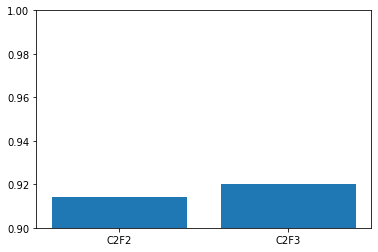

In [20]:
x = np.arange(2)
cnns = ['C2F2','C2F3']

plt.bar(x, accuracies)
plt.xticks(x, cnns)
plt.ylim((.9,1.0))
plt.show()

## Graph of loss and accuracy
- model: C2F2

In [21]:
c2f2 = keras.models.Sequential([ 
    Conv2D(input_shape=(28,28,1),kernel_size=(3,3),strides=(1,1),filters= 32,padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)), 
    Conv2D(kernel_size=(3,3),strides=(1,1),filters= 64,padding='same',activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Flatten(), 
    keras.layers.Dense(128, activation='relu'),  
    keras.layers.Dropout(0.25), 
    keras.layers.Dense(10, activation='softmax')
])

c2f2.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [22]:
c2f2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               401536    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

In [23]:
hist = c2f2.fit(X_train, y_train, 
         epochs = 20 , 
         batch_size =32, 
         validation_data=(X_test,y_test))

Epoch 1/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4340 - accuracy: 0.8434 - val_loss: 0.3141 - val_accuracy: 0.8874
Epoch 2/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2831 - accuracy: 0.8967 - val_loss: 0.2745 - val_accuracy: 0.8993
Epoch 3/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2390 - accuracy: 0.9130 - val_loss: 0.2531 - val_accuracy: 0.9081
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2087 - accuracy: 0.9233 - val_loss: 0.2336 - val_accuracy: 0.9168
Epoch 5/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1843 - accuracy: 0.9308 - val_loss: 0.2328 - val_accuracy: 0.9169
Epoch 6/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1640 - accuracy: 0.9389 - val_loss: 0.2349 - val_accuracy: 0.9204
Epoch 7/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1472 - accuracy: 0.9459 - val_loss: 0.2381 - val_accuracy:

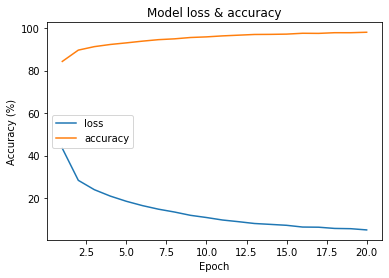

In [24]:
# Plot loass and accuracy
# Plot training & validation accuracy values
epochs = 20
loss_list = [100 * i for i in hist.history['loss']]
acc_list = [100 * i for i in hist.history['accuracy']]
plt.plot(range(1,epochs+1),loss_list) 
plt.plot(range(1,epochs+1),acc_list) 
plt.title('Model loss & accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['loss', 'accuracy'], loc='center left')

In [25]:
vloss_list = [100 * i for i in hist.history['val_loss']]
vacc_list = [100 * i for i in hist.history['val_accuracy']]

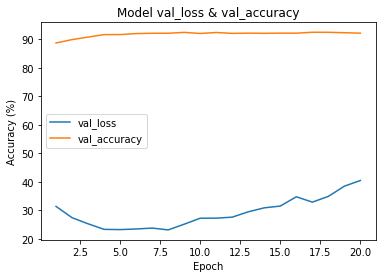

In [26]:
plt.plot(range(1,epochs+1),vloss_list)  
plt.plot(range(1,epochs+1),vacc_list)  
plt.title('Model val_loss & val_accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['val_loss', 'val_accuracy'], loc='center left')

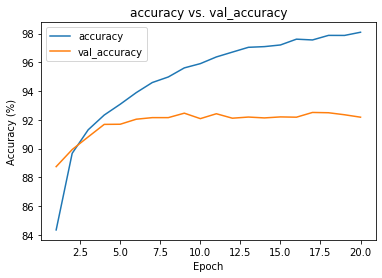

In [27]:
plt.plot(range(1,epochs+1),acc_list)  
plt.plot(range(1,epochs+1),vacc_list)  
plt.title('accuracy vs. val_accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['accuracy','val_accuracy']) #, loc='center bottom')

## 모형의 저장

- 트레이닝이 끝난 모형은 save 메서드로 가중치와 함께 hdf5 형식으로 저장
- load 명령으로 불러 사용

In [28]:
# c2f2.save('fmnist_cnn_best.hdf5')

In [31]:
from keras.models import load_model

model = load_model('fmnist_c2f3_best_weights.019-0.9264.hdf5')
model.evaluate(X_test, y_test, batch_size=32)

313/313 [==============================] - 1s 2ms/step - loss: 0.3299 - accuracy: 0.9264


[0.32994788885116577, 0.9264000058174133]

## Confusion matrix

In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [33]:
predictions = model.predict(X_test)

In [34]:
predictions.shape

(10000, 10)

In [35]:
predictions0 = np.argmax(predictions, axis=1)
predictions0.shape

(10000,)

In [36]:
cm = confusion_matrix(y_test0, predictions0)

In [37]:
class_names =  ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

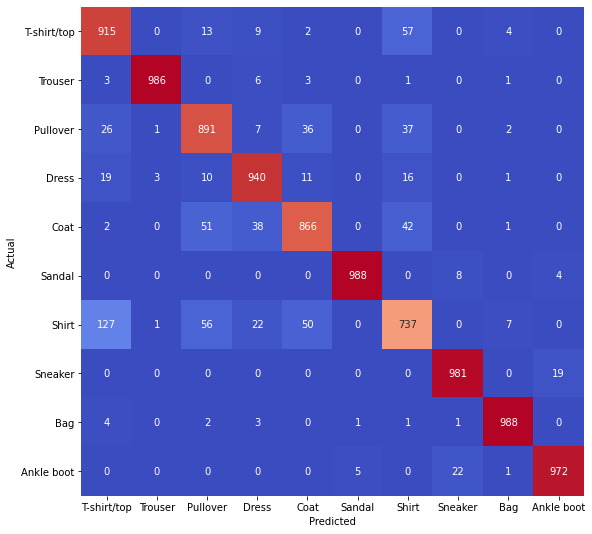

In [38]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, cbar=False, xticklabels=class_names, yticklabels=class_names, fmt='d', annot=True, cmap=plt.cm.coolwarm)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()